# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## 共通の関数を定義

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def get_dprinter(debug=True):
    def dprint(*args, **kwargs):
        if debug:
            print(*args, **kwargs)     
    return dprint

    
def build_hamiltonian(mol):
    E_nuc = mol.energy_nuc()
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] # creates Hamiltonian
    H_mat = H_mat + E_nuc * np.eye(H_mat.shape[0])
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    E_HF = myhf.e_tot

    return H_mat, E_fci, E_HF


def FCIQMC(mol, shift=0, init_n_walker=1, n_steps=5000, step_starting_shift_upd=500, n_prod=2500,
           shift_upd_interval=10, dt=0.001, damping=0.05, debug=True):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて基底状態エネルギーを推定する。

    Args:
        mol: PySCFのMoleculeオブジェクト
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        n_prod: E_projの平均を計算するステップ数（処理完了時からこのステップ数遡って平均を取る）
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ
        debug: デバッグモード
        

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """
    dprint = get_dprinter(debug)
    
    H_mat, E_fci, E_HF = build_hamiltonian(mol)
    H_mat = H_mat - np.eye(H_mat.shape[0]) * E_HF
    dprint(f"--- K Matrix shape:{H_mat.shape} ---")
    dprint(H_mat)
    
    E_est = 0
    hist_population, hist_shift, hist_energy = [], [], []
    
    diag_H = np.diag(H_mat)    
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    walkers = {ref_det_idx: init_n_walker}

    tqdm_pbar = tqdm(range(n_steps))
    for step in tqdm_pbar:
        new_walkers = defaultdict(int)
        
        # walkersが乗っている行列式の全てのインデックスを取得
        current_dets = list(walkers.keys())
        
        for i in current_dets:
            n_i = walkers[i] # ith行列式上のウォーカー数（符号付き）
            if n_i == 0: continue

            # ----- Spawning Step -----
            row = H_mat[i]
            # 非ゼロ要素のインデックスを取得
            connected_dets = np.where(row != 0)[0]
            # 対角要素は自分自身への遷移を表すので処理しない
            connected_dets = connected_dets[connected_dets != i]
            # ランダムに遷移先determinant jを候補に選ぶ
            j = np.random.choice(connected_dets)
            h_ij = row[j]

            # Spawning probability: Ps = dt * |H_ij|
            # 生成される数: sign(walker) * sign(-H_ij)
            p_gen = 1/len(connected_dets)
            prob_spawn = dt * abs(h_ij) / p_gen

            # 全てのwalkerに対して、spawnを試みる
            n_spawn = np.full(abs(n_i), 0)
            prob_spawn_frac, prob_spawn_int = math.modf(prob_spawn)
            if prob_spawn_int > 1:
                n_spawn = np.full(abs(n_i), prob_spawn_int)
            n_spawn += (np.random.rand(abs(n_i)) <= prob_spawn).astype(int)
            
            # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerを遷移先jth行列式の上に生成
            if h_ij > 0:
                new_walkers[j] += -np.sign(n_i) * np.sum(n_spawn)
            else:
                new_walkers[j] += np.sign(n_i) * np.sum(n_spawn)


            # ----- Diagonal Step (Death/Cloning) -----
            # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
            h_ii = diag_H[i]
            prob_death = dt * (h_ii - shift)
            n_walker_on_D = n_i
            sign = np.sign(n_walker_on_D)

            # prob_deathの確率でdeath/cloneする（対象となるwalkerの数をカウントする）
            count = np.sum(np.random.rand(abs(n_i)) <= abs(prob_death))
            if prob_death > 0:
                # prob_deathが正ならwalkerをcount分消滅させる
                n_walker_on_D = sign * (abs(n_walker_on_D) - count)
            else:
                # prob_deathが負ならwalkerをcount分複製する
                n_walker_on_D = sign * (abs(n_walker_on_D) + count)    
            walkers[i] = n_walker_on_D
            

        # ----- Annihilation Step -----
        for idx, n in new_walkers.items():
            walkers[idx] = walkers.get(idx, 0) + n

        # ---- Shift Update -----
        current_pop = sum(abs(w) for w in walkers.values())
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift
        hist_shift.append(shift)
        pre_pop = current_pop
        hist_population.append(current_pop)
        
        # ----- Energy Estimation (Projected Energy) -----
        # E_HF2 = diag_H[ref_det_idx]  # これはE_HFではない
        row0 = H_mat[ref_det_idx]
        num_ref = walkers.get(ref_det_idx, 0)

        # 論文では、singles/doublesに限定して合計している
        # この実装だとそもそもFCI行列の成分がsingles/doubles以外が0になっているので、
        # 全部を合計していて、結局singles/doublesだけが合計されることになっている
        E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        
        # 生成したコードでは論文にはない項を足していた
        # これはハミルトニアンに各反発エネルギーが含まれているかいないかの解釈が論文と異なっているため？
        # これを含めなければ近い値に収束するので、コメントアウトしておく
        # E_proj += mol.energy_nuc()
        hist_energy.append(E_proj)

        if step % 1000 == 0:
            tqdm_pbar.set_postfix(n_walkwers=current_pop, shift=f"{shift:.5f}", E_proj=f"{E_proj:.6f}")
            log_n_walkers(walkers, debug=debug)
    
    # n_prod件のhist_energyデータを10分割して平均を取り、標準偏差を求める
    n_block = 10
    hist_energy_prod = np.array(hist_energy[-n_prod:])
    block_size = len(hist_energy_prod) // n_block
    hist_energy_prod = hist_energy_prod[:n_block * block_size]  # 小数分を切り捨てる
    blocks = hist_energy_prod.reshape(n_block, block_size)
    block_means = blocks.mean(axis=1)
    E_sd = np.std(block_means, ddof=1)
    E_est = np.mean(block_means)
    
    # E_est = np.mean(hist_energy_prod) # 最後のn_prodステップの平均
    avg_shift = np.mean(hist_shift[-n_prod:]) # 最後のn_prodステップの平均
    
    dprint('\n---- Walkers (result) ----')
    log_n_walkers(walkers, debug=debug)

    return E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy


def log_n_walkers(walkers, debug=True, limit=10):
    dprint = get_dprinter(debug)
    sorted_list = sorted(
        ((k, v) for k, v in walkers.items() if v != 0),
        key=lambda x: abs(x[1]),
        reverse=True
    )
    for k, v in sorted_list[:limit]:
        dprint(f"  {v} walkers on {k}th determinant")

    if len(sorted_list) > limit:
        dprint("  ... more")


def plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_population)
    plt.xlabel('Step')
    plt.ylabel('Population')
    plt.yscale('log')
    plt.grid(True)  

    E_corr = np.full_like(hist_shift, E_fci - E_HF)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_shift, label="Shift")
    plt.plot(E_corr, linestyle="--", label=r"${E_{corr}}$")
    plt.xlabel('Step')
    plt.ylabel('Shift')
    plt.legend()
    plt.grid(True)  

    E_fci_arr = np.full_like(hist_energy, E_fci)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_energy, label=r"${E_{proj}}$")
    plt.plot(E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
    plt.xlabel('Step')
    plt.ylabel('Projected Energy')
    plt.legend()
    plt.grid(True)  
    
    plt.show()

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは近い値が出る

--- K Matrix shape:(4, 4) ---
[[ 0.00000000e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16  7.67196412e-01  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01  7.67196412e-01  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  1.57937745e+00]]


 11%|█████████▋                                                                                | 3210/30000 [00:00<00:00, 32092.30it/s]

Step 0: Walkers=1, Shift=0.70000, E_proj=-1.116759
  1 walkers on 0th determinant
Step 1000: Walkers=1, Shift=0.70000, E_proj=-1.116759
  1 walkers on 0th determinant
Step 2000: Walkers=4, Shift=0.70000, E_proj=-1.177163
  3 walkers on 0th determinant
  -1 walkers on 3th determinant
Step 3000: Walkers=10, Shift=0.70000, E_proj=-1.136894
  9 walkers on 0th determinant
  -1 walkers on 3th determinant
Step 4000: Walkers=17, Shift=0.70000, E_proj=-1.172516
  13 walkers on 0th determinant
  -4 walkers on 3th determinant
Step 5000: Walkers=26, Shift=0.70000, E_proj=-1.140395
  23 walkers on 0th determinant
  -3 walkers on 3th determinant
Step 6000: Walkers=68, Shift=0.70000, E_proj=-1.137554
  61 walkers on 0th determinant
  -7 walkers on 3th determinant


 21%|███████████████████▎                                                                      | 6420/30000 [00:00<00:00, 30644.27it/s]

Step 7000: Walkers=135, Shift=0.70000, E_proj=-1.144638
  117 walkers on 0th determinant
  -18 walkers on 3th determinant
Step 8000: Walkers=279, Shift=0.70000, E_proj=-1.136974
  251 walkers on 0th determinant
  -28 walkers on 3th determinant


 32%|████████████████████████████▍                                                             | 9489/30000 [00:00<00:00, 29515.57it/s]

Step 9000: Walkers=578, Shift=0.70000, E_proj=-1.140519
  511 walkers on 0th determinant
  -67 walkers on 3th determinant
Step 10000: Walkers=1197, Shift=0.70000, E_proj=-1.141736
  1052 walkers on 0th determinant
  -145 walkers on 3th determinant
Step 11000: Walkers=2064, Shift=0.41792, E_proj=-1.137940
  1848 walkers on 0th determinant
  -216 walkers on 3th determinant


 41%|████████████████████████████████████▉                                                    | 12446/30000 [00:00<00:00, 24427.49it/s]

Step 12000: Walkers=3020, Shift=0.24473, E_proj=-1.140130
  2675 walkers on 0th determinant
  -345 walkers on 3th determinant
Step 13000: Walkers=3753, Shift=0.15647, E_proj=-1.137294
  3371 walkers on 0th determinant
  -382 walkers on 3th determinant
Step 14000: Walkers=4348, Shift=0.08256, E_proj=-1.138669
  3879 walkers on 0th determinant
  -469 walkers on 3th determinant


 50%|████████████████████████████████████████████▍                                            | 14988/30000 [00:00<00:00, 20009.14it/s]

Step 15000: Walkers=4754, Shift=0.05136, E_proj=-1.138583
  4243 walkers on 0th determinant
  -511 walkers on 3th determinant


 57%|██████████████████████████████████████████████████▊                                      | 17134/30000 [00:00<00:00, 17140.75it/s]

Step 16000: Walkers=5048, Shift=0.02716, E_proj=-1.138196
  4514 walkers on 0th determinant
  -534 walkers on 3th determinant
Step 17000: Walkers=5223, Shift=0.01925, E_proj=-1.137052
  4697 walkers on 0th determinant
  -526 walkers on 3th determinant
Step 18000: Walkers=5378, Shift=-0.01641, E_proj=-1.137738
  4820 walkers on 0th determinant
  -558 walkers on 3th determinant


 63%|████████████████████████████████████████████████████████▎                                | 18975/30000 [00:00<00:00, 15393.50it/s]

Step 19000: Walkers=5387, Shift=-0.01356, E_proj=-1.136450
  4859 walkers on 0th determinant
  -528 walkers on 3th determinant
Step 20000: Walkers=5428, Shift=-0.05424, E_proj=-1.140297
  4804 walkers on 0th determinant
  -624 walkers on 3th determinant


 69%|█████████████████████████████████████████████████████████████                            | 20601/30000 [00:01<00:00, 14507.22it/s]

Step 21000: Walkers=5203, Shift=-0.06353, E_proj=-1.138484
  4646 walkers on 0th determinant
  -557 walkers on 3th determinant


 78%|█████████████████████████████████████████████████████████████████████▊                   | 23525/30000 [00:01<00:00, 13649.55it/s]

Step 22000: Walkers=5101, Shift=-0.03528, E_proj=-1.138793
  4548 walkers on 0th determinant
  -553 walkers on 3th determinant
Step 23000: Walkers=5007, Shift=-0.02222, E_proj=-1.136639
  4512 walkers on 0th determinant
  -495 walkers on 3th determinant
Step 24000: Walkers=4962, Shift=-0.01813, E_proj=-1.135452
  4498 walkers on 0th determinant
  -464 walkers on 3th determinant


 87%|█████████████████████████████████████████████████████████████████████████████▊           | 26249/30000 [00:01<00:00, 13339.68it/s]

Step 25000: Walkers=4978, Shift=-0.02711, E_proj=-1.137263
  4472 walkers on 0th determinant
  -506 walkers on 3th determinant
Step 26000: Walkers=4969, Shift=-0.00182, E_proj=-1.135335
  4507 walkers on 0th determinant
  -462 walkers on 3th determinant


 92%|█████████████████████████████████████████████████████████████████████████████████▊       | 27586/30000 [00:01<00:00, 13159.95it/s]

Step 27000: Walkers=4981, Shift=-0.03391, E_proj=-1.137249
  4475 walkers on 0th determinant
  -506 walkers on 3th determinant


 96%|█████████████████████████████████████████████████████████████████████████████████████▋   | 28903/30000 [00:01<00:00, 12979.91it/s]

Step 28000: Walkers=4933, Shift=-0.02378, E_proj=-1.137062
  4436 walkers on 0th determinant
  -497 walkers on 3th determinant
Step 29000: Walkers=4943, Shift=-0.01869, E_proj=-1.136925
  4448 walkers on 0th determinant
  -495 walkers on 3th determinant


100%|█████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 16236.52it/s]



---- Walkers (result) ----
  4463 walkers on 0th determinant
  -488 walkers on 3th determinant
E_fci=-1.137283834488502, E_HF=-1.1167593073964248
------------------------------
FCI Energy: -1.137284 Ha
Final FCIQMC Energy: -1.137177 ±  0.001118 Ha
Average shift: -0.028836 Ha => Energy: -1.1455955227792267


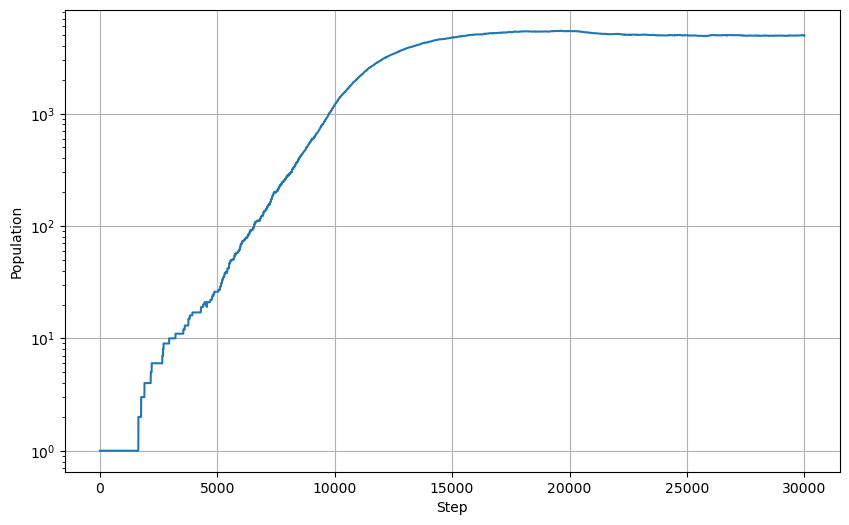

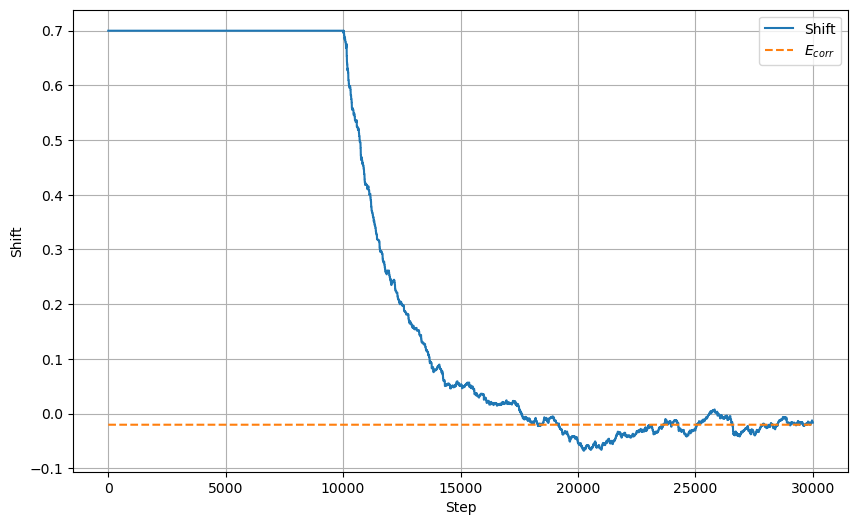

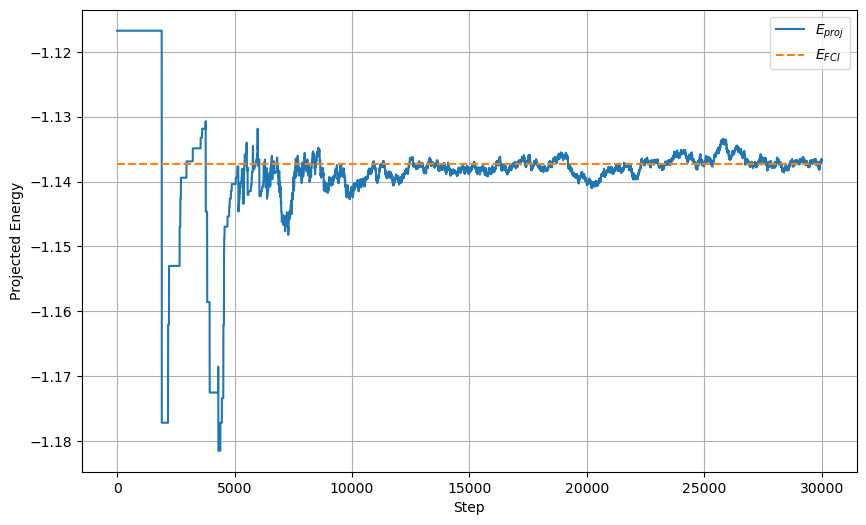

In [81]:
from pyscf import gto

# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)

E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, init_n_walker=1, n_steps=30000, n_prod=10000, step_starting_shift_upd=10000)

print(f"E_fci={E_fci}, E_HF={E_HF}")

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${H_3^+}$ (sto-3g)
FCI行列は9x9

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
--- FCI Matrix ---
(9, 9)
[[-1.24591513e+00  2.78282448e-17 -9.82897130e-09  2.78282448e-17
   1.44076448e-01 -4.65022949e-17 -9.82897130e-09 -4.65022949e-17
   1.44076569e-01]
 [ 2.78282448e-17 -6.16148605e-01 -4.94150488e-17  1.44076448e-01
   2.23904423e-12 -9.56437226e-02 -4.65022949e-17 -9.56440818e-02
  -2.23896578e-12]
 [-9.82897130e-09 -4.94150488e-17 -6.16130888e-01 -4.65022949e-17
  -9.56437226e-02 -2.23892764e-12  1.44076569e-01 -2.23896578e-12
   9.56396165e-02]
 [ 2.78282448e-17  1.44076448e-01 -4.65022949e-17 -6.16148605e-01
   2.23904423e-12 -9.56440818e-02 -4.94150488e-17 -9.56437226e-02
  -2.23896578e-12]
 [ 1.44076448e-01  2.23904423e-12 -9.56437226e-02  2.23904423e-12
   1.13702477e-01 -3.38168990e-16 -9.56437226e-02 -3.38168990e-16
   7.58871399e-02]
 [-4.65022949e-17 -9.56437226e-02 -2.23892764e-12 -9.56440

 14%|████████████▍                                                                             | 2763/20000 [00:00<00:00, 27617.38it/s]

Step 0: Walkers=1, Shift=0.80000, E_proj=-1.245915
  1 walkers on 0th determinant
Step 1000: Walkers=3, Shift=0.80000, E_proj=-1.245915
  3 walkers on 0th determinant
Step 2000: Walkers=5, Shift=0.80000, E_proj=-1.245915
  5 walkers on 0th determinant
Step 3000: Walkers=31, Shift=0.80000, E_proj=-1.310750
  20 walkers on 0th determinant
  -1 walkers on 2th determinant
  -6 walkers on 4th determinant
  -1 walkers on 6th determinant
  -3 walkers on 8th determinant


 28%|████████████████████████▊                                                                 | 5525/20000 [00:00<00:01, 13919.89it/s]

Step 4000: Walkers=55, Shift=0.80000, E_proj=-1.285536
  40 walkers on 0th determinant
  -8 walkers on 4th determinant
  -4 walkers on 6th determinant
  -3 walkers on 8th determinant
Step 5000: Walkers=118, Shift=0.80000, E_proj=-1.287798
  86 walkers on 0th determinant
  1 walkers on 2th determinant
  -15 walkers on 4th determinant
  -6 walkers on 6th determinant
  -10 walkers on 8th determinant
Step 6000: Walkers=242, Shift=0.80000, E_proj=-1.276843
  191 walkers on 0th determinant
  -2 walkers on 2th determinant
  -25 walkers on 4th determinant
  -8 walkers on 6th determinant
  -16 walkers on 8th determinant


 43%|██████████████████████████████████████▊                                                   | 8628/20000 [00:00<00:01, 11232.45it/s]

Step 7000: Walkers=507, Shift=0.80000, E_proj=-1.266403
  436 walkers on 0th determinant
  -2 walkers on 2th determinant
  -32 walkers on 4th determinant
  -7 walkers on 6th determinant
  -30 walkers on 8th determinant
Step 8000: Walkers=1173, Shift=0.80000, E_proj=-1.272471
  982 walkers on 0th determinant
  -1 walkers on 2th determinant
  -99 walkers on 4th determinant
  -9 walkers on 6th determinant
  -82 walkers on 8th determinant


 49%|████████████████████████████████████████████▎                                             | 9853/20000 [00:00<00:01, 10073.46it/s]

Step 9000: Walkers=2686, Shift=0.80000, E_proj=-1.272383
  2259 walkers on 0th determinant
  -3 walkers on 2th determinant
  -181 walkers on 4th determinant
  -9 walkers on 6th determinant
  -234 walkers on 8th determinant
Step 10000: Walkers=6175, Shift=0.80000, E_proj=-1.274244
  5152 walkers on 0th determinant
  2 walkers on 2th determinant
  -459 walkers on 4th determinant
  8 walkers on 6th determinant
  -554 walkers on 8th determinant


 59%|█████████████████████████████████████████████████████▏                                    | 11817/20000 [00:01<00:01, 6958.62it/s]

Step 11000: Walkers=12054, Shift=0.49802, E_proj=-1.274486
  10030 walkers on 0th determinant
  15 walkers on 2th determinant
  -917 walkers on 4th determinant
  20 walkers on 6th determinant
  -1072 walkers on 8th determinant


 63%|████████████████████████████████████████████████████████▌                                 | 12564/20000 [00:01<00:01, 5772.48it/s]

Step 12000: Walkers=18239, Shift=0.27219, E_proj=-1.274795
  15186 walkers on 0th determinant
  4 walkers on 2th determinant
  -1645 walkers on 4th determinant
  -5 walkers on 6th determinant
  -1399 walkers on 8th determinant


 66%|███████████████████████████████████████████████████████████▎                              | 13186/20000 [00:01<00:01, 4955.59it/s]

Step 13000: Walkers=22909, Shift=0.14186, E_proj=-1.273392
  19197 walkers on 0th determinant
  47 walkers on 2th determinant
  -1958 walkers on 4th determinant
  -4 walkers on 6th determinant
  -1703 walkers on 8th determinant


 71%|███████████████████████████████████████████████████████████████▊                          | 14169/20000 [00:02<00:01, 3878.91it/s]

Step 14000: Walkers=26592, Shift=0.08691, E_proj=-1.275099
  22038 walkers on 0th determinant
  43 walkers on 2th determinant
  -2114 walkers on 4th determinant
  47 walkers on 6th determinant
  -2350 walkers on 8th determinant


 76%|████████████████████████████████████████████████████████████████████▋                     | 15269/20000 [00:02<00:01, 3141.78it/s]

Step 15000: Walkers=29253, Shift=0.01651, E_proj=-1.276032
  24149 walkers on 0th determinant
  -11 walkers on 2th determinant
  -2618 walkers on 4th determinant
  45 walkers on 6th determinant
  -2430 walkers on 8th determinant


 82%|█████████████████████████████████████████████████████████████████████████▉                | 16432/20000 [00:02<00:01, 2752.30it/s]

Step 16000: Walkers=30119, Shift=-0.00320, E_proj=-1.275456
  24913 walkers on 0th determinant
  -38 walkers on 2th determinant
  -2778 walkers on 4th determinant
  60 walkers on 6th determinant
  -2330 walkers on 8th determinant


 88%|██████████████████████████████████████████████████████████████████████████████▊           | 17500/20000 [00:03<00:00, 2634.89it/s]

Step 17000: Walkers=30185, Shift=-0.01282, E_proj=-1.272969
  25360 walkers on 0th determinant
  -51 walkers on 2th determinant
  -2484 walkers on 4th determinant
  12 walkers on 6th determinant
  -2278 walkers on 8th determinant


 92%|██████████████████████████████████████████████████████████████████████████████████▎       | 18305/20000 [00:03<00:00, 2531.17it/s]

Step 18000: Walkers=30865, Shift=-0.04630, E_proj=-1.275309
  25552 walkers on 0th determinant
  -64 walkers on 2th determinant
  -2456 walkers on 4th determinant
  36 walkers on 6th determinant
  -2757 walkers on 8th determinant


 97%|███████████████████████████████████████████████████████████████████████████████████████   | 19343/20000 [00:04<00:00, 2567.80it/s]

Step 19000: Walkers=30621, Shift=-0.00677, E_proj=-1.273760
  25628 walkers on 0th determinant
  15 walkers on 2th determinant
  -2623 walkers on 4th determinant
  -25 walkers on 6th determinant
  -2330 walkers on 8th determinant


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4701.77it/s]



---- Walkers (result) ----
25721 walkers on 0th determinant
6 walkers on 2th determinant
-2559 walkers on 4th determinant
-17 walkers on 6th determinant
-2392 walkers on 8th determinant
------------------------------
FCI Energy: -1.274275 Ha
Final FCIQMC Energy: -1.274824 ±  0.000873 Ha
Average shift: 0.130721 Ha => Energy: -1.1151937009939108


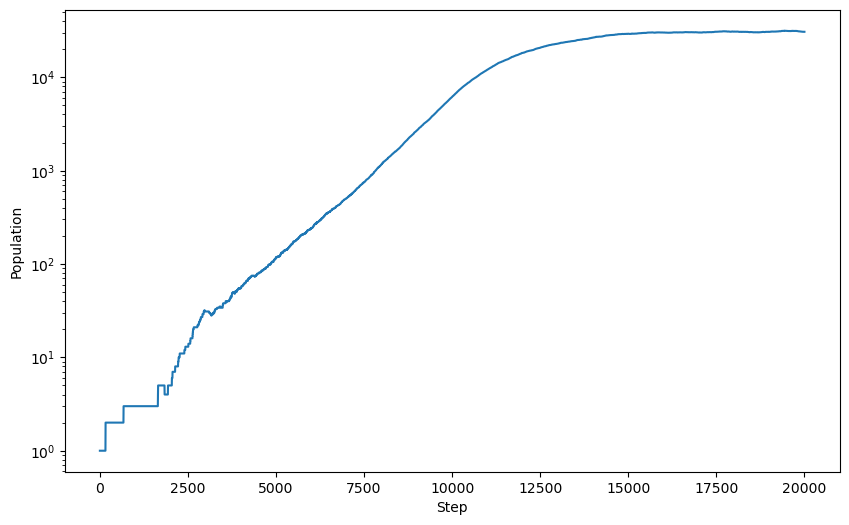

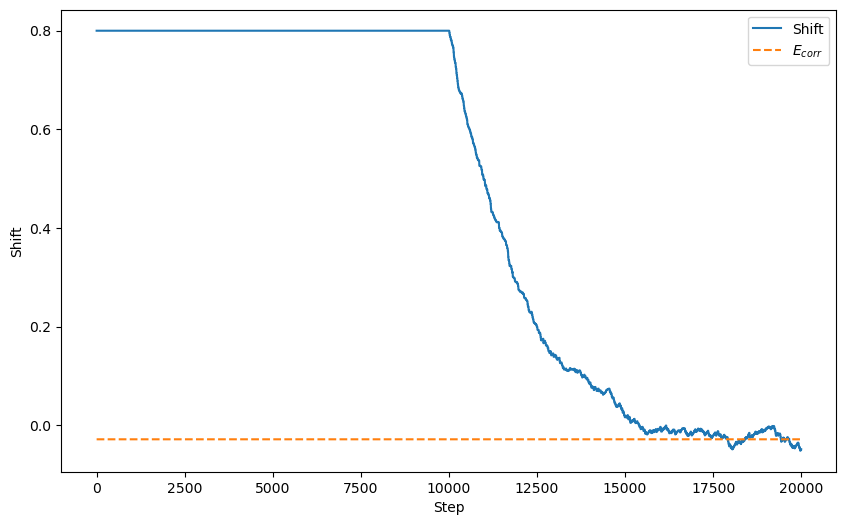

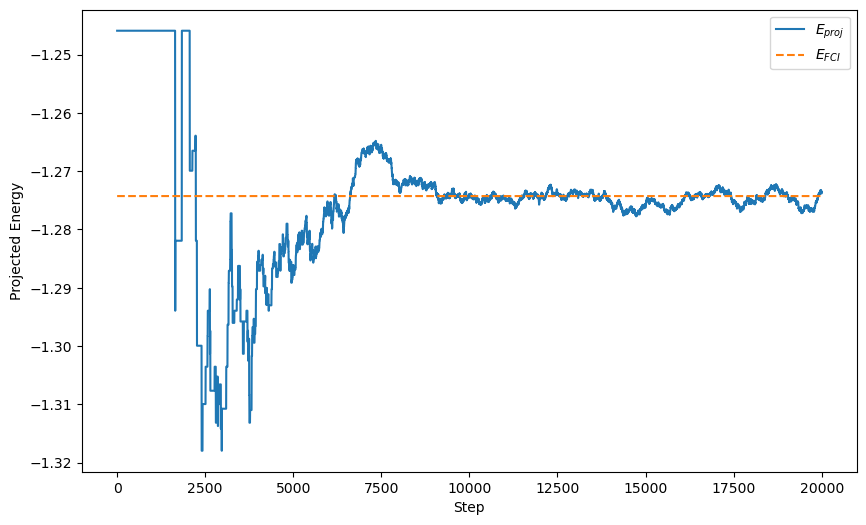

In [119]:
from pyscf import gto

# H3+分子の定義
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.8, n_steps=20000, n_prod=10000, step_starting_shift_upd=10000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ STO-3G
FCI行列は225x225

--- K Matrix shape:(225, 225) ---
[[ 0.00000000e+00  1.27143117e-08 -1.26874917e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143117e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26874917e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  6.39953052e+00
   9.78985494e-18  1.39675606e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.78985494e-18
   6.44660276e+00  2.84038987e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.39675606e-18
   2.84038987e-17  6.48034104e+00]]


  4%|███▌                                                                                        | 762/20000 [00:00<00:02, 7611.70it/s]

Step 0: Walkers=1, Shift=0.70000, E_proj=-7.861865
  1 walkers on 0th determinant
Step 1000: Walkers=3, Shift=0.70000, E_proj=-7.923828
  2 walkers on 0th determinant
  -1 walkers on 160th determinant


  8%|███████▌                                                                                   | 1671/20000 [00:00<00:02, 8378.23it/s]

Step 2000: Walkers=3, Shift=0.70000, E_proj=-7.923828

 19%|█████████████████                                                                         | 3778/20000 [00:00<00:01, 10010.62it/s]


  2 walkers on 0th determinant
  -1 walkers on 160th determinant
Step 3000: Walkers=4, Shift=0.70000, E_proj=-7.903174
  3 walkers on 0th determinant
  -1 walkers on 160th determinant
Step 4000: Walkers=8, Shift=0.70000, E_proj=-7.861865
  8 walkers on 0th determinant


 30%|███████████████████████████▎                                                               | 5993/20000 [00:00<00:01, 8899.38it/s]

Step 5000: Walkers=15, Shift=0.70000, E_proj=-7.883608
  12 walkers on 0th determinant
  -2 walkers on 160th determinant
  -1 walkers on 16th determinant
Step 6000: Walkers=41, Shift=0.70000, E_proj=-7.878648
  33 walkers on 0th determinant
  -4 walkers on 160th determinant
  -1 walkers on 32th determinant
  -1 walkers on 16th determinant
  -1 walkers on 48th determinant
  -1 walkers on 78th determinant


 39%|███████████████████████████████████                                                        | 7716/20000 [00:01<00:01, 6217.65it/s]

Step 7000: Walkers=82, Shift=0.70000, E_proj=-7.873611
  68 walkers on 0th determinant
  -5 walkers on 160th determinant
  2 walkers on 25th determinant
  -2 walkers on 16th determinant
  1 walkers on 151th determinant
  -1 walkers on 96th determinant
  1 walkers on 167th determinant
  -1 walkers on 48th determinant
  -1 walkers on 181th determinant


 42%|██████████████████████████████████████▏                                                    | 8398/20000 [00:01<00:02, 5121.36it/s]

Step 8000: Walkers=163, Shift=0.70000, E_proj=-7.871219
  135 walkers on 0th determinant
  -7 walkers on 160th determinant
  4 walkers on 25th determinant
  -4 walkers on 96th determinant
  -4 walkers on 16th determinant
  2 walkers on 151th determinant
  1 walkers on 63th determinant
  1 walkers on 152th determinant
  1 walkers on 10th determinant
  1 walkers on 40th determinant
  ... more


 47%|██████████████████████████████████████████▉                                                | 9448/20000 [00:01<00:02, 3730.74it/s]

Step 9000: Walkers=294, Shift=0.35824, E_proj=-7.873858
  238 walkers on 0th determinant
  -17 walkers on 160th determinant
  8 walkers on 25th determinant
  5 walkers on 151th determinant
  -4 walkers on 96th determinant
  -4 walkers on 48th determinant
  -3 walkers on 16th determinant
  2 walkers on 15th determinant
  -2 walkers on 176th determinant
  -2 walkers on 32th determinant
  ... more


 53%|███████████████████████████████████████████████▌                                          | 10556/20000 [00:02<00:03, 3011.76it/s]

Step 10000: Walkers=432, Shift=0.14987, E_proj=-7.887987
  310 walkers on 0th determinant
  -53 walkers on 160th determinant
  17 walkers on 25th determinant
  13 walkers on 151th determinant
  -8 walkers on 96th determinant
  -8 walkers on 48th determinant
  3 walkers on 1th determinant
  -3 walkers on 16th determinant
  -2 walkers on 112th determinant
  2 walkers on 15th determinant
  ... more


 57%|███████████████████████████████████████████████████▍                                      | 11430/20000 [00:02<00:03, 2650.86it/s]

Step 11000: Walkers=495, Shift=0.08581, E_proj=-7.882159
  360 walkers on 0th determinant
  -41 walkers on 160th determinant
  24 walkers on 25th determinant
  21 walkers on 151th determinant
  -12 walkers on 48th determinant
  -9 walkers on 16th determinant
  -8 walkers on 96th determinant
  -3 walkers on 32th determinant
  3 walkers on 1th determinant
  2 walkers on 10th determinant
  ... more


 62%|███████████████████████████████████████████████████████▊                                  | 12394/20000 [00:02<00:03, 2223.18it/s]

Step 12000: Walkers=519, Shift=0.06558, E_proj=-7.878790
  397 walkers on 0th determinant
  -39 walkers on 160th determinant
  26 walkers on 151th determinant
  15 walkers on 25th determinant
  -11 walkers on 48th determinant
  -5 walkers on 96th determinant
  -5 walkers on 16th determinant
  4 walkers on 1th determinant
  3 walkers on 166th determinant
  2 walkers on 10th determinant
  ... more


 66%|███████████████████████████████████████████████████████████▊                              | 13282/20000 [00:03<00:03, 2151.45it/s]

Step 13000: Walkers=543, Shift=-0.04571, E_proj=-7.880324
  405 walkers on 0th determinant
  -44 walkers on 160th determinant
  23 walkers on 151th determinant
  15 walkers on 25th determinant
  -15 walkers on 48th determinant
  -8 walkers on 96th determinant
  -7 walkers on 16th determinant
  5 walkers on 63th determinant
  5 walkers on 1th determinant
  3 walkers on 111th determinant
  ... more


 71%|████████████████████████████████████████████████████████████████                          | 14227/20000 [00:03<00:02, 2250.16it/s]

Step 14000: Walkers=543, Shift=0.00043, E_proj=-7.877488
  408 walkers on 0th determinant
  -37 walkers on 160th determinant
  16 walkers on 151th determinant
  14 walkers on 25th determinant
  -13 walkers on 16th determinant
  -10 walkers on 96th determinant
  -10 walkers on 48th determinant
  -5 walkers on 15th determinant
  4 walkers on 63th determinant
  4 walkers on 1th determinant
  ... more


 77%|████████████████████████████████████████████████████████████████████▉                     | 15316/20000 [00:04<00:02, 2064.01it/s]

Step 15000: Walkers=574, Shift=0.01800, E_proj=-7.882724
  422 walkers on 0th determinant
  -57 walkers on 160th determinant
  18 walkers on 151th determinant
  14 walkers on 25th determinant
  -13 walkers on 48th determinant
  -8 walkers on 96th determinant
  8 walkers on 1th determinant
  -5 walkers on 16th determinant
  4 walkers on 49th determinant
  -2 walkers on 15th determinant
  ... more


 81%|█████████████████████████████████████████████████████████████████████████                 | 16241/20000 [00:04<00:01, 2265.87it/s]

Step 16000: Walkers=595, Shift=0.01806, E_proj=-7.882147
  444 walkers on 0th determinant
  -56 walkers on 160th determinant
  23 walkers on 151th determinant
  17 walkers on 25th determinant
  -16 walkers on 48th determinant
  -6 walkers on 96th determinant
  5 walkers on 15th determinant
  5 walkers on 1th determinant
  -5 walkers on 16th determinant
  5 walkers on 49th determinant
  ... more


 86%|█████████████████████████████████████████████████████████████████████████████▊            | 17295/20000 [00:05<00:01, 2481.24it/s]

Step 17000: Walkers=598, Shift=-0.02465, E_proj=-7.879230
  453 walkers on 0th determinant
  -44 walkers on 160th determinant
  27 walkers on 151th determinant
  23 walkers on 25th determinant
  -18 walkers on 96th determinant
  7 walkers on 1th determinant
  -7 walkers on 48th determinant
  5 walkers on 15th determinant
  3 walkers on 49th determinant
  -2 walkers on 112th determinant
  ... more


 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 18284/20000 [00:05<00:00, 2400.68it/s]

Step 18000: Walkers=606, Shift=-0.11459, E_proj=-7.880776
  452 walkers on 0th determinant
  -52 walkers on 160th determinant
  20 walkers on 25th determinant
  19 walkers on 151th determinant
  -14 walkers on 96th determinant
  -13 walkers on 48th determinant
  11 walkers on 1th determinant
  6 walkers on 15th determinant
  -3 walkers on 16th determinant
  2 walkers on 97th determinant
  ... more


 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 19206/20000 [00:05<00:00, 2071.35it/s]

Step 19000: Walkers=588, Shift=-0.03763, E_proj=-7.880099
  424 walkers on 0th determinant
  -43 walkers on 160th determinant
  26 walkers on 151th determinant
  17 walkers on 25th determinant
  -15 walkers on 48th determinant
  -12 walkers on 96th determinant
  11 walkers on 1th determinant
  -9 walkers on 16th determinant
  5 walkers on 15th determinant
  -4 walkers on 32th determinant
  ... more


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:06<00:00, 3137.37it/s]



---- Walkers (result) ----
  404 walkers on 0th determinant
  -40 walkers on 160th determinant
  24 walkers on 151th determinant
  23 walkers on 25th determinant
  -20 walkers on 48th determinant
  15 walkers on 1th determinant
  -13 walkers on 96th determinant
  -7 walkers on 16th determinant
  5 walkers on 15th determinant
  -4 walkers on 32th determinant
  ... more
------------------------------
FCI Energy: -7.882324 Ha
Final FCIQMC Energy: -7.879988 ±  0.002072 Ha
Average shift: 0.002391 Ha => Energy: -7.859473948483107


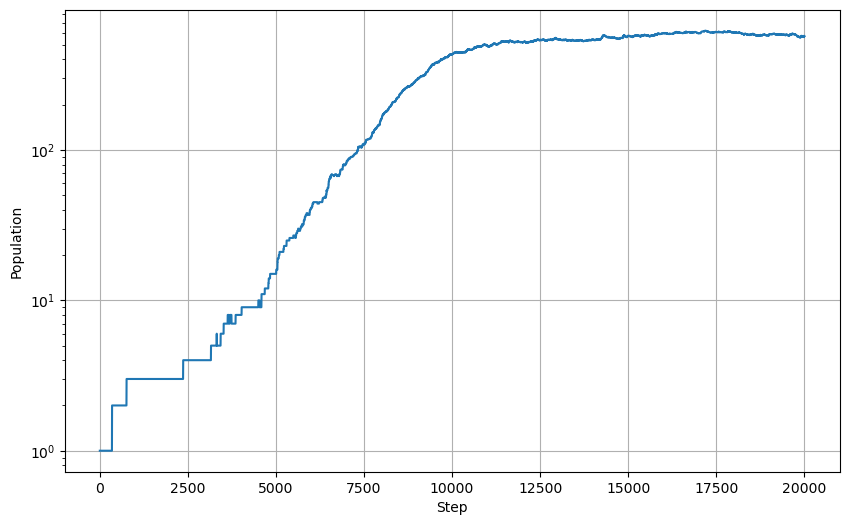

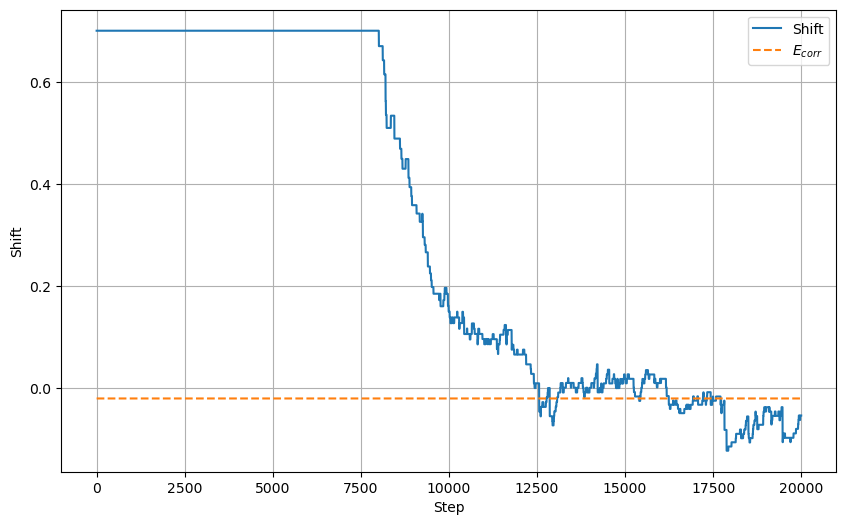

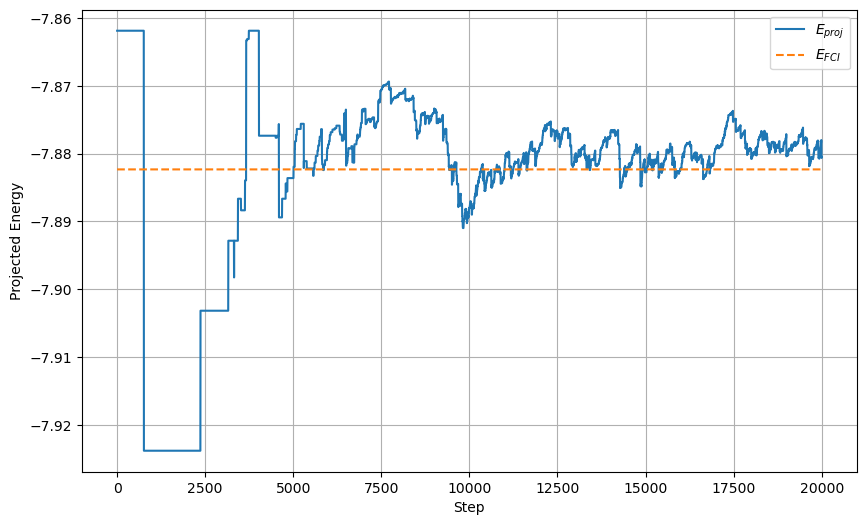

In [75]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    # basis="6-31g",
    # basis="6-31g(d)",
    # basis="6-31g(d,p)",
    spin=0,      # singlet
    verbose=0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, n_steps=20000, n_prod=10000, step_starting_shift_upd=8000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ 6-31g(d,p)
FCI行列は?x?

--- K Matrix shape:(29241, 29241) ---
[[ 1.77635684e-15 -8.13150965e-08 -8.36649967e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.13150965e-08  1.49183480e-01 -3.73250995e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.36649967e-09 -3.73250995e-03  2.21133798e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.59440770e+01
   7.42439937e-18 -3.68253891e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  7.42439937e-18
   1.72874354e+01  5.26243800e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.68253891e-17
   5.26243800e-17  1.73991629e+01]]


  2%|▋                                            | 607/40000 [00:00<00:06, 6066.06it/s, E_proj=-7.981176, n_walkwers=1, shift=0.70000]

  1 walkers on 0th determinant


  3%|█▎                                          | 1214/40000 [00:00<00:10, 3582.63it/s, E_proj=-8.084695, n_walkwers=2, shift=0.70000]

  1 walkers on 0th determinant
  -1 walkers on 18060th determinant


  5%|██▎                                         | 2133/40000 [00:01<00:27, 1397.32it/s, E_proj=-8.023448, n_walkwers=8, shift=0.70000]

  2 walkers on 0th determinant
  1 walkers on 17991th determinant
  -1 walkers on 6156th determinant
  -1 walkers on 105th determinant
  -1 walkers on 6192th determinant
  -1 walkers on 6441th determinant
  -1 walkers on 22188th determinant


  8%|███▎                                        | 3032/40000 [00:02<01:21, 452.26it/s, E_proj=-8.020990, n_walkwers=21, shift=0.70000]

  -4 walkers on 6156th determinant
  3 walkers on 0th determinant
  1 walkers on 17956th determinant
  -1 walkers on 3636th determinant
  1 walkers on 7723th determinant
  -1 walkers on 18060th determinant
  1 walkers on 1th determinant
  -1 walkers on 105th determinant
  -1 walkers on 1710th determinant
  1 walkers on 15597th determinant
  ... more


 10%|████▍                                       | 4030/40000 [00:07<03:36, 166.05it/s, E_proj=-7.967615, n_walkwers=60, shift=0.70000]

  7 walkers on 0th determinant
  -5 walkers on 6156th determinant
  3 walkers on 1th determinant
  2 walkers on 36th determinant
  2 walkers on 91th determinant
  2 walkers on 17965th determinant
  -2 walkers on 15666th determinant
  1 walkers on 9408th determinant
  1 walkers on 20640th determinant
  -1 walkers on 3636th determinant
  ... more


 13%|█████▌                                      | 5015/40000 [00:15<05:32, 105.16it/s, E_proj=-7.982803, n_walkwers=96, shift=0.70000]

  13 walkers on 0th determinant
  -6 walkers on 6156th determinant
  5 walkers on 1th determinant
  3 walkers on 17956th determinant
  3 walkers on 91th determinant
  3 walkers on 6166th determinant
  2 walkers on 181th determinant
  2 walkers on 10th determinant
  -2 walkers on 7698th determinant
  -2 walkers on 1710th determinant
  ... more


 15%|██████▌                                     | 6015/40000 [00:27<07:40, 73.79it/s, E_proj=-7.998365, n_walkwers=190, shift=0.70000]

  37 walkers on 0th determinant
  10 walkers on 1th determinant
  -8 walkers on 6156th determinant
  -4 walkers on 15th determinant
  -4 walkers on 1710th determinant
  3 walkers on 17956th determinant
  3 walkers on 10th determinant
  3 walkers on 91th determinant
  -3 walkers on 15597th determinant
  -3 walkers on 23392th determinant
  ... more


 18%|███████▋                                    | 7011/40000 [00:41<09:04, 60.64it/s, E_proj=-8.009674, n_walkwers=337, shift=0.70000]

  70 walkers on 0th determinant
  16 walkers on 1th determinant
  -14 walkers on 6156th determinant
  -11 walkers on 1710th determinant
  -9 walkers on 15652th determinant
  -7 walkers on 20640th determinant
  -6 walkers on 23392th determinant
  -5 walkers on 15th determinant
  -5 walkers on 6157th determinant
  5 walkers on 171th determinant
  ... more


 20%|████████▊                                   | 8009/40000 [00:59<10:50, 49.16it/s, E_proj=-7.997187, n_walkwers=528, shift=0.70000]

  116 walkers on 0th determinant
  32 walkers on 1th determinant
  -20 walkers on 1710th determinant
  -17 walkers on 6156th determinant
  16 walkers on 10th determinant
  -10 walkers on 15th determinant
  -8 walkers on 6157th determinant
  -7 walkers on 172th determinant
  7 walkers on 1047th determinant
  -6 walkers on 6192th determinant
  ... more


 23%|█████████▋                                 | 9007/40000 [01:22<12:42, 40.65it/s, E_proj=-8.006074, n_walkwers=1031, shift=0.70000]

  247 walkers on 0th determinant
  61 walkers on 1th determinant
  -32 walkers on 1710th determinant
  -29 walkers on 6156th determinant
  27 walkers on 10th determinant
  20 walkers on 1815th determinant
  -17 walkers on 15th determinant
  -16 walkers on 172th determinant
  -16 walkers on 6192th determinant
  -16 walkers on 6157th determinant
  ... more


 25%|██████████▌                               | 10005/40000 [01:50<15:39, 31.94it/s, E_proj=-8.013558, n_walkwers=2093, shift=0.70000]

  561 walkers on 0th determinant
  109 walkers on 1th determinant
  43 walkers on 10th determinant
  -42 walkers on 6156th determinant
  -41 walkers on 1720th determinant
  -38 walkers on 26316th determinant
  -32 walkers on 6192th determinant
  -32 walkers on 1710th determinant
  -28 walkers on 6157th determinant
  -27 walkers on 172th determinant
  ... more


 28%|███████████▌                              | 11004/40000 [02:26<19:14, 25.12it/s, E_proj=-8.005172, n_walkwers=3392, shift=0.46069]

  1018 walkers on 0th determinant
  174 walkers on 1th determinant
  -93 walkers on 1720th determinant
  64 walkers on 10th determinant
  -55 walkers on 9460th determinant
  -54 walkers on 26254th determinant
  -54 walkers on 6192th determinant
  -49 walkers on 172th determinant
  -47 walkers on 1710th determinant
  -45 walkers on 1711th determinant
  ... more


 30%|████████████▌                             | 12003/40000 [03:08<20:15, 23.04it/s, E_proj=-8.001447, n_walkwers=4630, shift=0.26186]

  1481 walkers on 0th determinant
  225 walkers on 1th determinant
  -149 walkers on 1720th determinant
  -98 walkers on 6157th determinant
  -85 walkers on 7740th determinant
  78 walkers on 17965th determinant
  71 walkers on 10th determinant
  -69 walkers on 1711th determinant
  -65 walkers on 26254th determinant
  -52 walkers on 1032th determinant
  ... more


 33%|█████████████▋                            | 13004/40000 [03:54<22:49, 19.71it/s, E_proj=-8.010075, n_walkwers=6075, shift=0.19154]

  1903 walkers on 0th determinant
  259 walkers on 1th determinant
  -212 walkers on 7740th determinant
  163 walkers on 1815th determinant
  160 walkers on 6261th determinant
  -148 walkers on 26316th determinant
  -95 walkers on 6157th determinant
  93 walkers on 10th determinant
  -92 walkers on 20565th determinant
  -92 walkers on 1720th determinant
  ... more


 35%|██████████████▋                           | 14004/40000 [04:43<21:40, 19.98it/s, E_proj=-8.003380, n_walkwers=6969, shift=0.18837]

  2285 walkers on 0th determinant
  320 walkers on 1th determinant
  -308 walkers on 1720th determinant
  -198 walkers on 6157th determinant
  -154 walkers on 6192th determinant
  86 walkers on 17965th determinant
  77 walkers on 10th determinant
  -75 walkers on 9460th determinant
  -68 walkers on 1710th determinant
  -67 walkers on 9411th determinant
  ... more


 38%|███████████████▊                          | 15004/40000 [05:39<24:02, 17.33it/s, E_proj=-8.008646, n_walkwers=8897, shift=0.13553]

  2902 walkers on 0th determinant
  -577 walkers on 6192th determinant
  414 walkers on 1th determinant
  -210 walkers on 1711th determinant
  -185 walkers on 1720th determinant
  -177 walkers on 6157th determinant
  -146 walkers on 558th determinant
  -132 walkers on 23392th determinant
  -131 walkers on 1746th determinant
  -125 walkers on 172th determinant
  ... more


 40%|████████████████▍                        | 16004/40000 [06:38<23:43, 16.85it/s, E_proj=-8.023435, n_walkwers=10330, shift=0.00080]

  3094 walkers on 0th determinant
  422 walkers on 1th determinant
  -318 walkers on 18060th determinant
  -308 walkers on 26316th determinant
  -297 walkers on 6192th determinant
  -256 walkers on 1711th determinant
  -215 walkers on 6157th determinant
  -194 walkers on 7740th determinant
  151 walkers on 1815th determinant
  149 walkers on 17956th determinant
  ... more


 43%|█████████████████▊                        | 17004/40000 [07:37<21:27, 17.86it/s, E_proj=-7.997656, n_walkwers=9127, shift=0.10793]

  3436 walkers on 0th determinant
  413 walkers on 1th determinant
  -181 walkers on 1711th determinant
  -160 walkers on 6157th determinant
  -154 walkers on 9460th determinant
  -148 walkers on 172th determinant
  116 walkers on 36th determinant
  113 walkers on 17956th determinant
  -104 walkers on 1746th determinant
  -104 walkers on 207th determinant
  ... more


 45%|██████████████████▍                      | 18004/40000 [08:36<23:08, 15.84it/s, E_proj=-8.017052, n_walkwers=12085, shift=0.18558]

  4138 walkers on 0th determinant
  -602 walkers on 18060th determinant
  450 walkers on 1th determinant
  -283 walkers on 6192th determinant
  201 walkers on 17965th determinant
  -181 walkers on 1720th determinant
  174 walkers on 17991th determinant
  -167 walkers on 7698th determinant
  -152 walkers on 6157th determinant
  142 walkers on 36th determinant
  ... more


 48%|███████████████████▍                     | 19002/40000 [09:45<26:15, 13.32it/s, E_proj=-8.002976, n_walkwers=15405, shift=0.23839]

  5228 walkers on 0th determinant
  508 walkers on 1th determinant
  -420 walkers on 207th determinant
  -380 walkers on 6157th determinant
  -347 walkers on 1720th determinant
  320 walkers on 17965th determinant
  -211 walkers on 7815th determinant
  -196 walkers on 6192th determinant
  -193 walkers on 1032th determinant
  -191 walkers on 172th determinant
  ... more


 50%|████████████████████▌                    | 20002/40000 [11:02<25:46, 12.93it/s, E_proj=-7.997807, n_walkwers=17047, shift=0.22725]

  6606 walkers on 0th determinant
  595 walkers on 1th determinant
  -367 walkers on 1711th determinant
  -360 walkers on 207th determinant
  -283 walkers on 1720th determinant
  -277 walkers on 9460th determinant
  -261 walkers on 6157th determinant
  -221 walkers on 15714th determinant
  -209 walkers on 26316th determinant
  -209 walkers on 4843th determinant
  ... more


 53%|█████████████████████▌                   | 21002/40000 [12:20<24:34, 12.89it/s, E_proj=-8.012449, n_walkwers=20200, shift=0.17546]

  7332 walkers on 0th determinant
  -974 walkers on 23392th determinant
  675 walkers on 1th determinant
  -399 walkers on 26316th determinant
  -370 walkers on 7740th determinant
  -352 walkers on 1720th determinant
  -338 walkers on 1711th determinant
  321 walkers on 1815th determinant
  -311 walkers on 9541th determinant
  279 walkers on 6261th determinant
  ... more


 55%|██████████████████████▌                  | 22002/40000 [13:45<26:40, 11.25it/s, E_proj=-8.016275, n_walkwers=26882, shift=0.23952]

  9638 walkers on 0th determinant
  -1442 walkers on 18060th determinant
  810 walkers on 1th determinant
  782 walkers on 17965th determinant
  -587 walkers on 1720th determinant
  -502 walkers on 6166th determinant
  -445 walkers on 1711th determinant
  441 walkers on 1815th determinant
  -400 walkers on 26254th determinant
  -379 walkers on 1746th determinant
  ... more


 58%|███████████████████████▌                 | 23002/40000 [15:22<28:48,  9.83it/s, E_proj=-8.001217, n_walkwers=32300, shift=0.24068]

  12357 walkers on 0th determinant
  880 walkers on 1th determinant
  767 walkers on 17956th determinant
  -751 walkers on 1711th determinant
  -698 walkers on 181th determinant
  -483 walkers on 1720th determinant
  479 walkers on 17991th determinant
  -456 walkers on 9460th determinant
  -390 walkers on 7815th determinant
  -352 walkers on 172th determinant
  ... more


 60%|████████████████████████▌                | 24002/40000 [17:17<33:53,  7.87it/s, E_proj=-8.006800, n_walkwers=44753, shift=0.21034]

  16518 walkers on 0th determinant
  1368 walkers on 17965th determinant
  -1239 walkers on 20565th determinant
  -1193 walkers on 7740th determinant
  -1181 walkers on 6192th determinant
  965 walkers on 1th determinant
  -857 walkers on 26316th determinant
  -831 walkers on 6157th determinant
  -740 walkers on 1711th determinant
  -630 walkers on 181th determinant
  ... more


 63%|█████████████████████████               | 25002/40000 [19:20<30:23,  8.23it/s, E_proj=-8.001376, n_walkwers=41614, shift=-0.23511]

  16237 walkers on 0th determinant
  -1100 walkers on 207th determinant
  -1032 walkers on 6157th determinant
  848 walkers on 1th determinant
  -786 walkers on 1711th determinant
  -698 walkers on 15652th determinant
  684 walkers on 6261th determinant
  -634 walkers on 181th determinant
  -531 walkers on 20640th determinant
  -511 walkers on 6192th determinant
  ... more


 65%|██████████████████████████              | 26002/40000 [21:07<25:38,  9.10it/s, E_proj=-8.007374, n_walkwers=32310, shift=-0.25434]

  11799 walkers on 0th determinant
  1083 walkers on 17991th determinant
  -910 walkers on 26316th determinant
  -804 walkers on 9460th determinant
  639 walkers on 1th determinant
  613 walkers on 6261th determinant
  -588 walkers on 6157th determinant
  -548 walkers on 1711th determinant
  -499 walkers on 4816th determinant
  -460 walkers on 181th determinant
  ... more


 68%|███████████████████████████             | 27003/40000 [22:43<21:12, 10.21it/s, E_proj=-8.023681, n_walkwers=30130, shift=-0.16350]

  9818 walkers on 0th determinant
  -1332 walkers on 18060th determinant
  -1194 walkers on 6192th determinant
  560 walkers on 1815th determinant
  -528 walkers on 26316th determinant
  -433 walkers on 6157th determinant
  425 walkers on 1th determinant
  -414 walkers on 26254th determinant
  -406 walkers on 9411th determinant
  -403 walkers on 7740th determinant
  ... more


 70%|████████████████████████████            | 28003/40000 [24:17<17:34, 11.38it/s, E_proj=-8.008104, n_walkwers=23265, shift=-0.20367]

  8513 walkers on 0th determinant
  -532 walkers on 18060th determinant
  -478 walkers on 6166th determinant
  -462 walkers on 181th determinant
  -403 walkers on 6192th determinant
  -383 walkers on 20640th determinant
  333 walkers on 1815th determinant
  327 walkers on 1th determinant
  -327 walkers on 207th determinant
  -284 walkers on 26254th determinant
  ... more


 73%|█████████████████████████████▋           | 29002/40000 [25:46<17:28, 10.49it/s, E_proj=-8.003461, n_walkwers=22804, shift=0.13277]

  8565 walkers on 0th determinant
  993 walkers on 17991th determinant
  -409 walkers on 172th determinant
  377 walkers on 6261th determinant
  -372 walkers on 9411th determinant
  -368 walkers on 9541th determinant
  -292 walkers on 15652th determinant
  -269 walkers on 181th determinant
  -269 walkers on 6166th determinant
  -267 walkers on 26254th determinant
  ... more


 75%|██████████████████████████████▊          | 30002/40000 [27:17<15:10, 10.99it/s, E_proj=-8.013777, n_walkwers=25438, shift=0.06224]

  9440 walkers on 0th determinant
  887 walkers on 17991th determinant
  -872 walkers on 18060th determinant
  -811 walkers on 6192th determinant
  -608 walkers on 15652th determinant
  -385 walkers on 181th determinant
  363 walkers on 6261th determinant
  355 walkers on 17956th determinant
  -329 walkers on 1720th determinant
  315 walkers on 36th determinant
  ... more


 78%|███████████████████████████████▊         | 31003/40000 [28:53<14:17, 10.49it/s, E_proj=-8.002491, n_walkwers=26026, shift=0.07115]

  9858 walkers on 0th determinant
  671 walkers on 17965th determinant
  -653 walkers on 6192th determinant
  -497 walkers on 6157th determinant
  -497 walkers on 1720th determinant
  -326 walkers on 3612th determinant
  -325 walkers on 15714th determinant
  -320 walkers on 26316th determinant
  311 walkers on 6247th determinant
  -271 walkers on 181th determinant
  ... more


 80%|████████████████████████████████▊        | 32002/40000 [30:26<12:41, 10.50it/s, E_proj=-8.003628, n_walkwers=29053, shift=0.17902]

  11457 walkers on 0th determinant
  -781 walkers on 1746th determinant
  -663 walkers on 6192th determinant
  -566 walkers on 181th determinant
  -476 walkers on 23392th determinant
  -464 walkers on 6157th determinant
  -434 walkers on 4843th determinant
  -426 walkers on 172th determinant
  -423 walkers on 20640th determinant
  -423 walkers on 9433th determinant
  ... more


 83%|█████████████████████████████████▊       | 33002/40000 [32:04<12:20,  9.45it/s, E_proj=-8.005431, n_walkwers=37093, shift=0.24160]

  13853 walkers on 0th determinant
  -968 walkers on 1746th determinant
  927 walkers on 17991th determinant
  -785 walkers on 6192th determinant
  -745 walkers on 7740th determinant
  630 walkers on 276th determinant
  -622 walkers on 6157th determinant
  -488 walkers on 172th determinant
  457 walkers on 1th determinant
  453 walkers on 17956th determinant
  ... more


 85%|██████████████████████████████████▊      | 34002/40000 [33:51<11:01,  9.07it/s, E_proj=-7.996688, n_walkwers=40124, shift=0.02908]

  15795 walkers on 0th determinant
  -866 walkers on 15652th determinant
  -864 walkers on 207th determinant
  -849 walkers on 181th determinant
  -591 walkers on 1746th determinant
  -553 walkers on 1711th determinant
  538 walkers on 1th determinant
  -422 walkers on 172th determinant
  412 walkers on 171th determinant
  399 walkers on 17956th determinant
  ... more


 88%|███████████████████████████████████▉     | 35002/40000 [35:41<08:59,  9.26it/s, E_proj=-7.995538, n_walkwers=38406, shift=0.11415]

  16677 walkers on 0th determinant
  -862 walkers on 181th determinant
  806 walkers on 276th determinant
  -641 walkers on 9541th determinant
  -636 walkers on 1746th determinant
  -596 walkers on 207th determinant
  -563 walkers on 1711th determinant
  554 walkers on 1th determinant
  -509 walkers on 15714th determinant
  -477 walkers on 4816th determinant
  ... more


 90%|████████████████████████████████████▉    | 36002/40000 [37:35<08:08,  8.19it/s, E_proj=-8.007103, n_walkwers=50324, shift=0.21575]

  19892 walkers on 0th determinant
  -2170 walkers on 26316th determinant
  1570 walkers on 6261th determinant
  1104 walkers on 17965th determinant
  966 walkers on 276th determinant
  -939 walkers on 6157th determinant
  -869 walkers on 181th determinant
  -763 walkers on 1746th determinant
  -746 walkers on 6166th determinant
  -688 walkers on 9411th determinant
  ... more


 93%|█████████████████████████████████████▉   | 37002/40000 [39:41<07:04,  7.07it/s, E_proj=-7.998830, n_walkwers=60529, shift=0.15775]

  24180 walkers on 0th determinant
  -1718 walkers on 9541th determinant
  -1676 walkers on 7740th determinant
  -1553 walkers on 6157th determinant
  1204 walkers on 17991th determinant
  -1190 walkers on 1720th determinant
  -993 walkers on 172th determinant
  -867 walkers on 1032th determinant
  -772 walkers on 181th determinant
  746 walkers on 276th determinant
  ... more


 95%|██████████████████████████████████████▉  | 38002/40000 [41:59<04:55,  6.77it/s, E_proj=-8.008056, n_walkwers=78751, shift=0.18508]

  28925 walkers on 0th determinant
  -3135 walkers on 7740th determinant
  2118 walkers on 17965th determinant
  -1952 walkers on 15652th determinant
  -1752 walkers on 1720th determinant
  -1610 walkers on 1746th determinant
  -1400 walkers on 172th determinant
  -1111 walkers on 6157th determinant
  -926 walkers on 20565th determinant
  -870 walkers on 18060th determinant
  ... more


 98%|███████████████████████████████████████ | 39002/40000 [44:19<02:08,  7.75it/s, E_proj=-8.023640, n_walkwers=68808, shift=-0.50404]

  24243 walkers on 0th determinant
  -2555 walkers on 26316th determinant
  -1907 walkers on 18060th determinant
  -1756 walkers on 1746th determinant
  -1475 walkers on 23392th determinant
  -1342 walkers on 26254th determinant
  1276 walkers on 6261th determinant
  -1092 walkers on 7740th determinant
  -945 walkers on 4833th determinant
  -893 walkers on 4843th determinant
  ... more


100%|████████████████████████████████████████| 40000/40000 [46:24<00:00, 14.37it/s, E_proj=-8.023640, n_walkwers=68808, shift=-0.50404]



---- Walkers (result) ----
  18351 walkers on 0th determinant
  -1076 walkers on 26254th determinant
  -974 walkers on 1720th determinant
  -917 walkers on 1746th determinant
  840 walkers on 1815th determinant
  838 walkers on 17965th determinant
  -752 walkers on 15652th determinant
  -726 walkers on 6192th determinant
  -707 walkers on 20565th determinant
  -697 walkers on 558th determinant
  ... more
------------------------------
FCI Energy: -8.008671 Ha
Final FCIQMC Energy: -8.005765 ±  0.005373 Ha
Average shift: 0.045033 Ha => Energy: -7.936142617456491


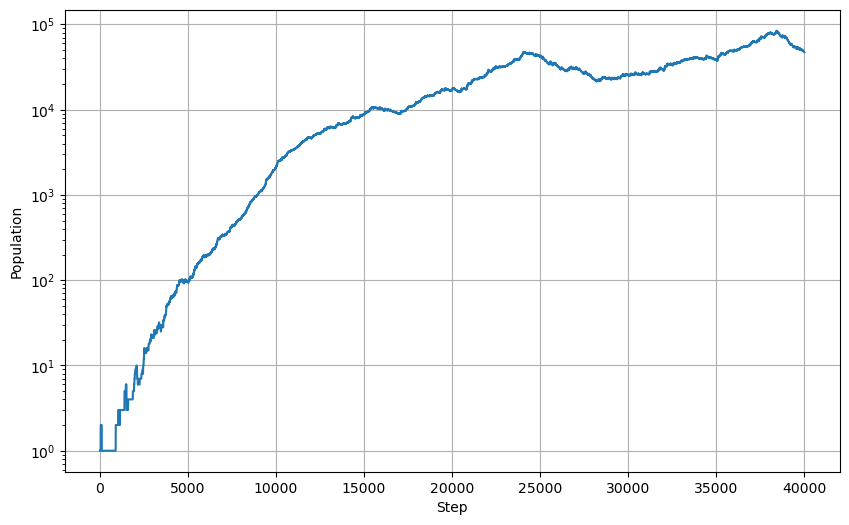

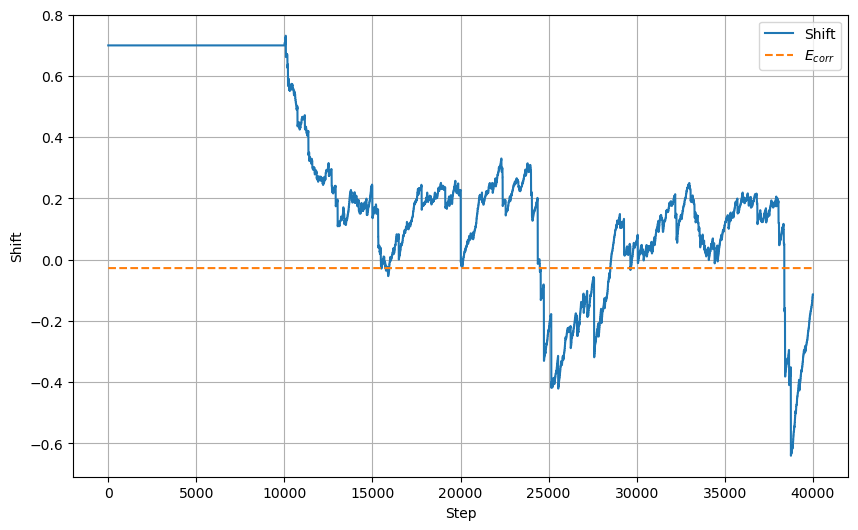

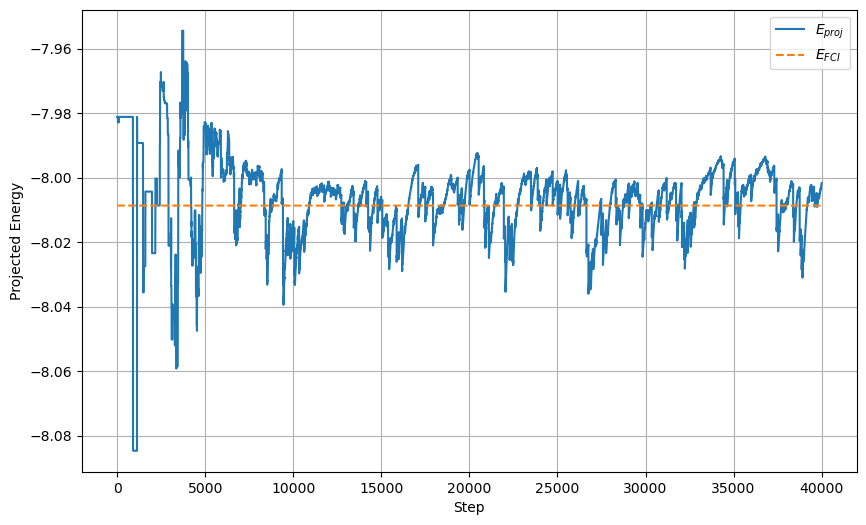

In [3]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="6-31g(d,p)",
    spin=0,      # singlet
    verbose=0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, n_steps=40000, n_prod=10000, step_starting_shift_upd=10000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ 分子 STO-3G, ステップ数ごとの標準偏差の確認
ステップ数を増やすと非常に実行に時間がかかる。

--- FCI Matrix ---
(225, 225)
[[-7.86186477e+00  1.27143444e-08 -1.26871539e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08 -7.70892352e+00 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871539e-10 -1.12113377e-02 -5.80885774e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.46233425e+00
   1.50382491e-17  8.78436185e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.50382491e-17
  -1.41526201e+00 -3.47698264e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.78436185e-18
  -3.47698264e-17 -1.38152373e+00]]
--- K Matrix ---
[[-1.77635684e-15  1.27143444e-08 -1.26871539e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871539e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 .

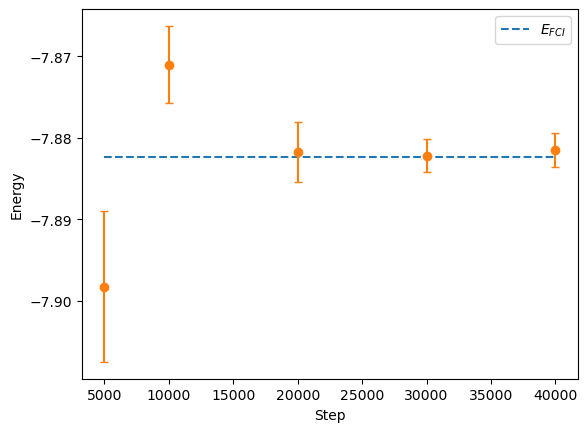

In [13]:
from pyscf import gto

n_steps_arr = [5000, 10000, 20000, 30000, 40000]

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    spin=0,      # singlet
    verbose=0
)

E = []
sd = []

for n_steps in n_steps_arr:
    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=1, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)

E_fci_arr = np.full_like(n_steps_arr, E_fci, dtype=float)
plt.plot(n_steps_arr, E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
plt.errorbar(n_steps_arr, E, yerr=sd, fmt='o', capsize=3)
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()

## ${N_2}$ at equilibrium
FCI行列が巨大過ぎて生成出来ない。必要な成分のみ取ってくる実装（on the fly?）に変える必要がありそう

In [ ]:
from pyscf import gto

# N2 at equilibriumの定義
R_bohr = 2.068     # a0
R_ang = R_bohr * 0.529177

mol = gto.M(
    atom=f"N 0 0 0; N 0 0 {R_ang}",
    basis="cc-pVDZ",
    unit="Angstrom",
    spin=0,      # singlet
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=1000, n_prod=500, step_starting_shift_upd=100)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## 外挿用（Det数:エネルギー）の共通関数を定義

In [5]:
def inverse_fit(N_det, E):
    x = 1.0 / N_det
    a, E_inf = np.polyfit(x, E, 1)
    fn = lambda N_det: a/N_det + E_inf    
    return a, E_inf, fn

def plot_extrapolation_to_inf_det(N_det, E, fn):    
    N_det_fit = np.linspace(N_det.min(), N_det.max(), 500)
    E_fit = fn(N_det_fit)

    plt.scatter(N_det, E, label="data")
    plt.plot(N_det_fit, E_fit, label=r"fit: $E_\infty + a/N$")
    plt.xlabel("Number of determinants")
    plt.ylabel("Energy")
    plt.legend()
    plt.show()

## ${H_2}$ 分子 基底数vs.エネルギーで外挿して、真のEを値を推測する

Starting FCIQMC with the 6-31g basis set.


100%|████████████████████████████████████████| 20000/20000 [00:02<00:00, 8316.68it/s, E_proj=-1.152258, n_walkwers=1227, shift=0.00628]


Starting FCIQMC with the 6-31g(d) basis set.


100%|█████████████████████████████████████████| 20000/20000 [00:01<00:00, 10041.10it/s, E_proj=-1.148768, n_walkwers=46, shift=0.19949]


Starting FCIQMC with the 6-31g(d,p) basis set.


100%|████████████████████████████████████████| 20000/20000 [00:05<00:00, 3535.62it/s, E_proj=-1.180135, n_walkwers=205, shift=-0.25342]


Starting FCIQMC with the 6-311G(d,p) basis set.


100%|█████████████████████████████████████████| 20000/20000 [00:08<00:00, 2375.84it/s, E_proj=-1.170090, n_walkwers=372, shift=0.01239]


All FCIQMC calculations have completed.
E_inf: -1.169159172070451


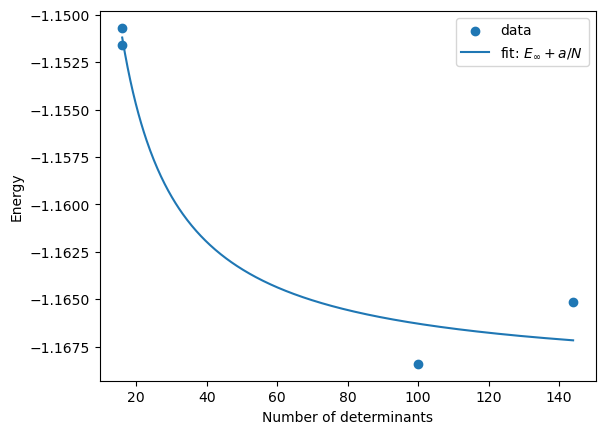

In [100]:
from pyscf import gto

# mol_1 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
mol_2 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g', verbose=0)
mol_3 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g(d)', verbose=0)
mol_4 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g(d,p)', verbose=0)
mol_5 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-311G(d,p)', verbose=0)
mols = [mol_2, mol_3, mol_4, mol_5]

n_steps = 20000
E = []
sd = []
N_det = np.zeros(len(mols))

for i, mol in enumerate(mols):
    print(f"Starting FCIQMC with the {mol.basis} basis set.")
    
    # determinantの数だけ欲しいが、molからは得られなかったので、
    # 冗長ではあるが、FCI Hamiltonianを生成して、行列の次元数を参照する
    H_mat, _, _ = build_hamiltonian(mol)

    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)
    N_det[i] = H_mat.shape[0]

print("All FCIQMC calculations have completed.")

_, E_inf, fn = inverse_fit(N_det, E)
print(f"E_inf: {E_inf}")

plot_extrapolation_to_inf_det(N_det, E, fn)


## ${LiH}$ 分子 基底数vs.エネルギーで外挿して、真のEを値を推測する

In [4]:
from pyscf import gto

mol_1 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='sto-3g', verbose=0)
mol_2 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g', verbose=0)
mol_3 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g(d)', verbose=0)
mol_4 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g(d,p)', verbose=0)
mols = [mol_1, mol_2, mol_3, mol_4]

n_steps = 40000
E = []
sd = []
N_det = np.zeros(len(mols))

for i, mol in enumerate(mols):
    print(f"Starting FCIQMC with the {mol.basis} basis set.")
    
    # determinantの数だけ欲しいが、molからは得られなかったので、
    # 冗長ではあるが、FCI Hamiltonianを生成して、行列の次元数を参照する
    H_mat, _, _ = build_hamiltonian(mol)

    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)
    N_det[i] = H_mat.shape[0]

print("All FCIQMC calculations have completed.")

Starting FCIQMC with the sto-3g basis set.


100%|███████████████████████████████████████| 40000/40000 [00:35<00:00, 1136.84it/s, E_proj=-7.880190, n_walkwers=9969, shift=-0.06585]


Starting FCIQMC with the 6-31g basis set.


100%|█████████████████████████████████████████| 40000/40000 [05:07<00:00, 130.04it/s, E_proj=-8.004459, n_walkwers=9421, shift=0.02323]


Starting FCIQMC with the 6-31g(d) basis set.


100%|████████████████████████████████████████| 40000/40000 [31:46<00:00, 20.98it/s, E_proj=-8.017295, n_walkwers=48951, shift=-0.04929]


Starting FCIQMC with the 6-31g(d,p) basis set.


100%|███████████████████████████████████████| 40000/40000 [1:27:23<00:00,  7.63it/s, E_proj=-8.008100, n_walkwers=94930, shift=0.10593]


All FCIQMC calculations have completed.


NameError: name 'inverse_fit' is not defined


Number of determinants: [  225.  3025. 14400. 29241.]
Energies: [np.float64(-7.8825610516142675), np.float64(-7.999504952870689), np.float64(-8.00476513085609), np.float64(-8.009363296702434)]
E_inf: -8.008650646649816


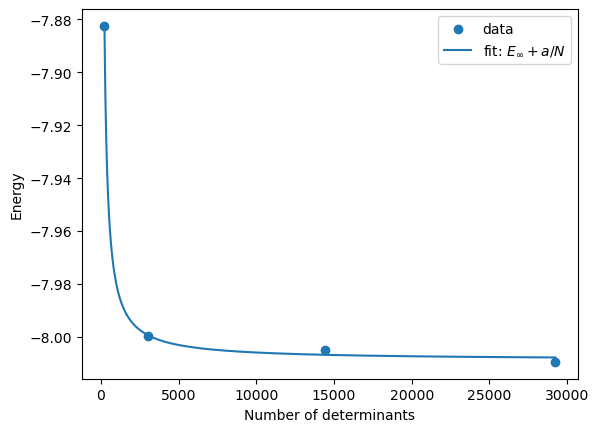

In [10]:
_, E_inf, fn = inverse_fit(N_det, E)

print(f"\nNumber of determinants: {N_det}")
print(f"Energies: {E}")
print(f"E_inf: {E_inf}")

plot_extrapolation_to_inf_det(N_det, E, fn)